# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [3]:
# <Student to fill this section>
import json
from api_helper_saurabh.data.sets import fetch_api_v0, fetch_api_v1

import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

In [4]:
# pip install api_helper_saurabh

---
## A. Project Description


In [5]:
# <Student to fill this section>
student_name = "Saurabh Sabharwal"
student_id = "25606169"

In [6]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [7]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [8]:
# <Student to fill this section>
business_use_case_description = """
The goal of this project is to clean a dataset, transform it and make a model that predicts if it's going to rain or not in t+7 days
"""

In [9]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [10]:
# <Student to fill this section>
business_objectives = """
Accuracy of results will impact weather reporting.
"""

In [11]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [12]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
The results can be used to publish weather update in Sydney. Client for this data and project is weather reporting agencies, and end users are going to be residents of Sydney, farmers, sports authorities (deciding which dates to select for a open-stadium matches)
"""

In [13]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


#### General

In [14]:
url_api = "https://archive-api.open-meteo.com/v1/archive?latitude=-33.8678&longitude=151.2073&start_date=2022-09-28&end_date=2025-09-28&daily=temperature_2m_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant&hourly=temperature_2m,wind_speed_100m,wind_direction_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,vapour_pressure_deficit,rain,precipitation,relative_humidity_2m,surface_pressure,direct_radiation_instant&timezone=Australia%2FSydney&wind_speed_unit=ms&timeformat=unixtime"

In [15]:
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": -33.8678,
    "longitude": 151.2073,
    "start_date": "2015-09-15",
    "end_date": "2025-09-15",   # shorten for test
    "daily": "temperature_2m_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant",
    "hourly": "temperature_2m,wind_speed_100m,wind_direction_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,vapour_pressure_deficit,rain,precipitation,relative_humidity_2m,surface_pressure,direct_radiation_instant",
    "timezone": "Australia/Sydney",
    "wind_speed_unit": "ms",
    "timeformat": "unixtime"
}

In [16]:
temp_df = fetch_api_v0(url=url, params=params)

In [17]:
import json

data = json.loads(temp_df.to_json())

In [18]:
hourly_data = pd.DataFrame(data["hourly"])
daily_data = pd.DataFrame(data["daily"])

# Convert time columns from UNIX to datetime
for df in [hourly_data, daily_data]:
    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"], unit="s")

In [19]:
print(daily_data.shape)
print(hourly_data.shape)

(3654, 27)
(87696, 27)


In [20]:
print(daily_data.info())
print(hourly_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   time                         3654 non-null   datetime64[ns]
 1   temperature_2m               0 non-null      object        
 2   wind_speed_100m              0 non-null      object        
 3   wind_direction_100m          0 non-null      object        
 4   soil_moisture_0_to_7cm       0 non-null      object        
 5   soil_moisture_7_to_28cm      0 non-null      object        
 6   soil_temperature_0_to_7cm    0 non-null      object        
 7   soil_temperature_7_to_28cm   0 non-null      object        
 8   cloud_cover                  0 non-null      object        
 9   cloud_cover_low              0 non-null      object        
 10  cloud_cover_mid              0 non-null      object        
 11  cloud_cover_high             0 non-null    

In [21]:
cols_to_drop = ['temperature_2m', 'wind_speed_100m', 'wind_direction_100m',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'vapour_pressure_deficit', 'rain', 'precipitation',
       'relative_humidity_2m', 'surface_pressure', 'direct_radiation_instant']

daily_data.drop(columns=cols_to_drop, inplace=True)
daily_data.shape

(3654, 10)

In [22]:
cols_to_drop = ['temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min',
       'sunshine_duration', 'rain_sum', 'precipitation_sum',
       'precipitation_hours', 'wind_speed_10m_max',
       'wind_direction_10m_dominant']

hourly_data.drop(columns=cols_to_drop, inplace=True)
hourly_data.shape

(87696, 18)

In [23]:
import os
print(os.getcwd())

C:\Users\lenovo\Desktop\Labs Sem 2\Adv ML\at2\saurabh-at2-eda-model\notebooks\rain_or_not


In [24]:
from pathlib import Path

class AT:
    def __init__(self, folder_path):
        self.folder_path = Path(folder_path)
        self.folder_path.mkdir(parents=True, exist_ok=True)  # <--- ensures folder exists

at = AT("../data/raw/classification")

In [25]:
# to avoid API runtime error, we are storing the daily_df and hourly_df locally
try:
    daily_data.to_csv(at.folder_path / "daily_df.csv", index=False)
    hourly_data.to_csv(at.folder_path / "hourly_df.csv", index=False)
except Exception as e:
    print(e)

#### For the first model, I will be using daily_df

In [26]:
df = pd.read_csv("../data/raw/classification/daily_df.csv")

In [27]:
df.head()

,time,temperature_2m_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant
0,2015-09-14 14:00:00,19.4,26.3,14.1,39629.22,0.1,0.1,1.0,7.39,310
1,2015-09-15 14:00:00,15.3,18.8,11.6,39829.05,0.0,0.0,0.0,4.52,165
2,2015-09-16 14:00:00,14.4,16.8,11.8,36662.08,4.4,4.4,11.0,4.98,172
3,2015-09-17 14:00:00,14.9,17.1,13.5,39506.63,1.0,1.0,5.0,5.00,179
4,2015-09-18 14:00:00,15.2,17.0,13.5,37697.60,3.4,3.4,14.0,4.14,130


In [28]:
df.tail()

,time,temperature_2m_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant
3649,2025-09-10 14:00:00,12.2,15.7,8.6,15181.43,35.3,35.3,14.0,9.31,227
3650,2025-09-11 14:00:00,13.3,18.8,9.3,39095.85,0.0,0.0,0.0,3.28,274
3651,2025-09-12 14:00:00,13.8,18.9,8.9,39097.41,0.0,0.0,0.0,3.69,0
3652,2025-09-13 14:00:00,14.9,21.1,9.3,39289.95,0.0,0.0,0.0,4.30,341
3653,2025-09-14 14:00:00,17.3,24.5,9.5,39585.54,0.0,0.0,0.0,4.08,327


In [29]:
# Ensure 'time' column is datetime
df['time'] = pd.to_datetime(df['time'])

# Keep only rows where date is before 2025-01-01
daily_df = df[df['time'] < '2025-01-01']

In [30]:
test_2025 = df[df['time'] > '2025-01-01'] # to be used later for the final predictions

In [31]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3397 entries, 0 to 3396
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   time                         3397 non-null   datetime64[ns]
 1   temperature_2m_mean          3397 non-null   float64       
 2   temperature_2m_max           3397 non-null   float64       
 3   temperature_2m_min           3397 non-null   float64       
 4   sunshine_duration            3397 non-null   float64       
 5   rain_sum                     3397 non-null   float64       
 6   precipitation_sum            3397 non-null   float64       
 7   precipitation_hours          3397 non-null   float64       
 8   wind_speed_10m_max           3397 non-null   float64       
 9   wind_direction_10m_dominant  3397 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 291.9 KB


In [32]:
daily_df.describe()

,time,temperature_2m_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant
count,3397,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000
mean,2020-05-08 14:00:00,17.511981,21.887047,13.547248,34101.761460,2.683132,2.683132,4.365322,5.761001,179.523403
min,2015-09-14 14:00:00,7.400000,9.800000,0.900000,0.000000,0.000000,0.000000,0.000000,1.600000,0.000000
25%,2018-01-10 14:00:00,13.800000,18.300000,9.700000,31319.010000,0.000000,0.000000,0.000000,4.400000,76.000000
50%,2020-05-08 14:00:00,17.700000,21.600000,13.600000,35840.960000,0.200000,0.200000,1.000000,5.550000,182.000000
75%,2022-09-04 14:00:00,20.900000,24.800000,17.600000,41932.380000,2.000000,2.000000,7.000000,6.910000,274.000000
max,2024-12-31 14:00:00,30.500000,41.800000,26.900000,48622.780000,138.400000,138.400000,24.000000,13.550000,360.000000
std,NaN,4.340243,4.663401,4.670281,11197.309952,7.221191,7.221191,6.078589,1.820563,105.127837


### C.2 Define Target variable

In [33]:
daily_df['rain_or_not_7d'] = (daily_df['rain_sum'].shift(-7) > 1).astype(int)

In [34]:
daily_df.shape

(3397, 11)

In [35]:
daily_df.tail()

,time,temperature_2m_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant,rain_or_not_7d
3392,2024-12-27 14:00:00,21.4,24.0,18.6,48554.49,0.9,0.9,8.0,5.60,109,0
3393,2024-12-28 14:00:00,22.2,27.9,16.9,48533.38,0.0,0.0,0.0,4.92,137,0
3394,2024-12-29 14:00:00,22.5,25.6,19.7,48509.53,0.3,0.3,2.0,5.07,85,0
3395,2024-12-30 14:00:00,23.0,26.5,18.7,42930.70,0.0,0.0,0.0,4.15,66,0
3396,2024-12-31 14:00:00,24.3,28.6,19.6,48453.72,0.0,0.0,0.0,6.05,47,0


In [36]:
# Drop the last 7 rows
daily_df = daily_df.iloc[:-7]
daily_df.shape

(3390, 11)

In [37]:
# <Student to fill this section>
target_definition_explanations = """
Target contains binary response, whether it will rain on (t+7)th day or not. Considering only those values as rain where there's more than 1mm of rain_sum. Last 7 records are deleted because they don't have any information of (t+7)th day
"""

In [38]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Explore Target variable

rain_or_not_7d
0    2283
1    1107
Name: count, dtype: int64


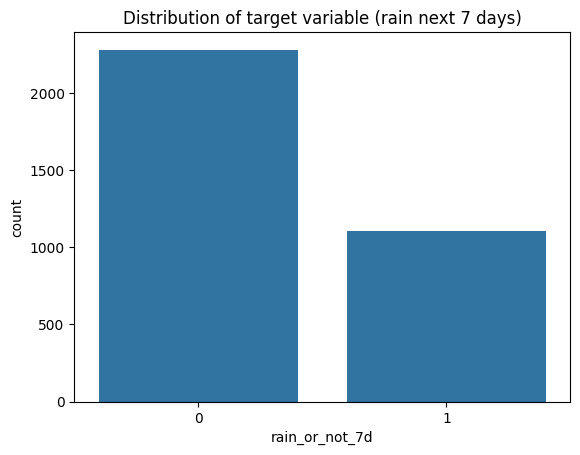

In [39]:
print(daily_df['rain_or_not_7d'].value_counts())

sns.countplot(x='rain_or_not_7d', data=daily_df)
plt.title("Distribution of target variable (rain next 7 days)")
plt.show()

In [40]:
# <Student to fill this section>
target_distribution_explanations = """
Distribution does not look highly imbalanced, no null values
"""

In [41]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.4 Explore Feature of Interest `temperature_2m_mean`, `temperature_2m_max`, `temperature_2m_min`

In [42]:
def plot_feature_vs_target(df, feature_col, target_col='rain_or_not_7d'):
    plt.figure(figsize=(6,3))
    sns.boxplot(x=target_col, y=feature_col, data=df)
    plt.title(f"{feature_col} vs {target_col}")
    plt.xlabel(target_col)
    plt.ylabel(feature_col)
    plt.grid()
    plt.show()

In [43]:
temp = daily_df[['temperature_2m_min','temperature_2m_mean','temperature_2m_max']]

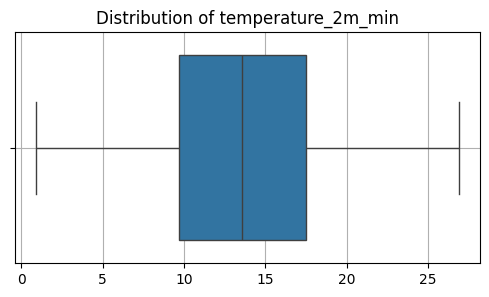

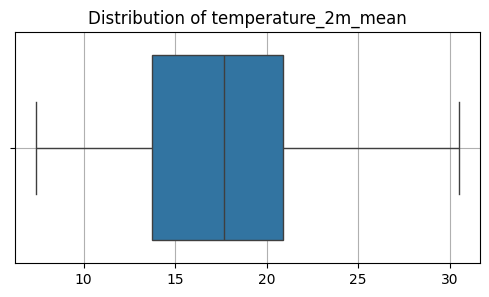

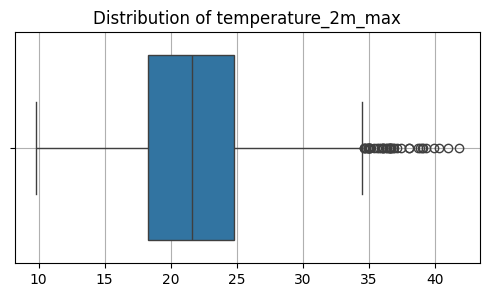

In [44]:
for col in temp.columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=temp[col])
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.grid()
    plt.show()

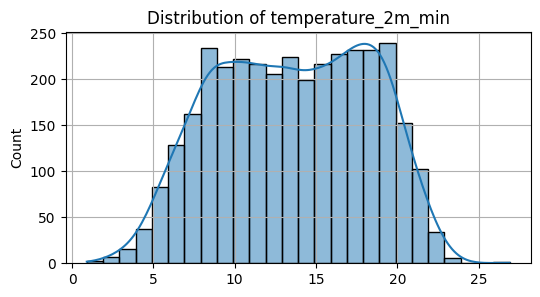

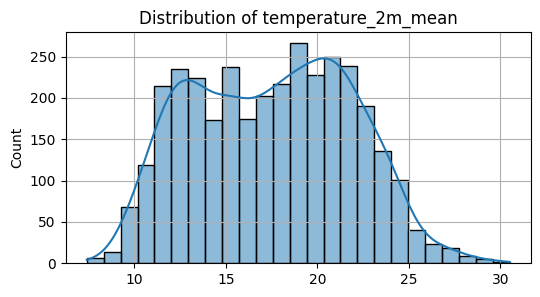

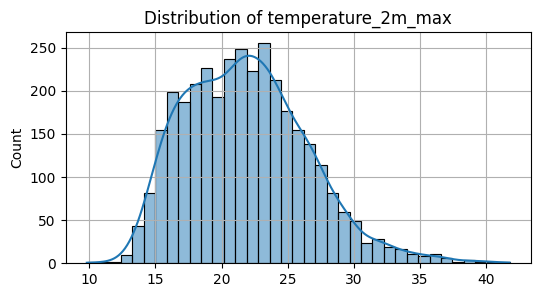

In [45]:
for col in temp.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(temp[col],kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.grid()
    plt.show()

In [46]:
temp['target'] = daily_df['rain_or_not_7d']

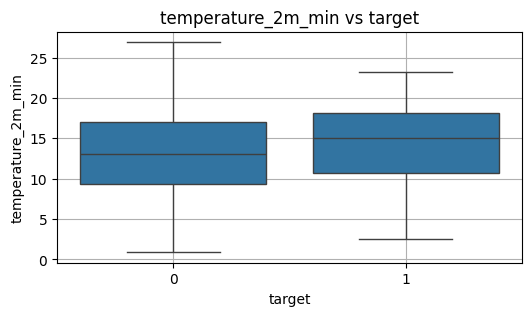

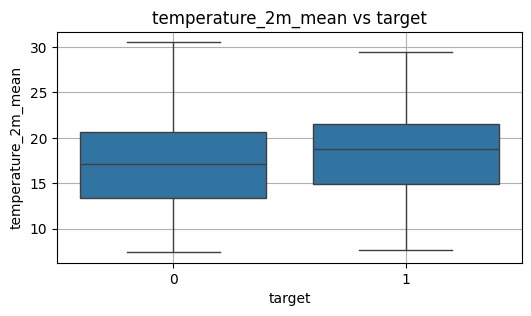

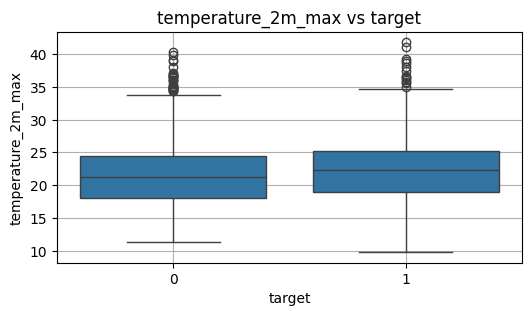

In [47]:
for col in temp.columns[0:-1]:
    plot_feature_vs_target(temp,col,'target')

In [48]:
# <Student to fill this section>
feature_1_insights = """
Outliers found in temperature_2m_max. There seems to be a relation of temperature with rainfall, higher temperature recorded when it rained, this could be because of higher amount of absorption and then precipitation.
"""

In [49]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.5 Explore Feature of Interest `sunshine_duration`

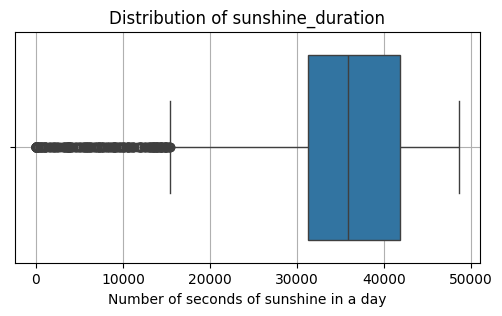

In [50]:
plt.figure(figsize=(6,3))
sns.boxplot(x=daily_df['sunshine_duration'])
plt.title(f"Distribution of sunshine_duration")
plt.xlabel("Number of seconds of sunshine in a day")
plt.grid()
plt.show()

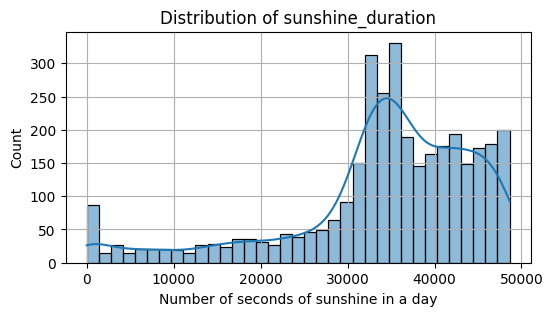

In [51]:
plt.figure(figsize=(6,3))
sns.histplot(daily_df['sunshine_duration'],kde=True)
plt.title(f"Distribution of sunshine_duration")
plt.xlabel("Number of seconds of sunshine in a day")
plt.grid()
plt.show()

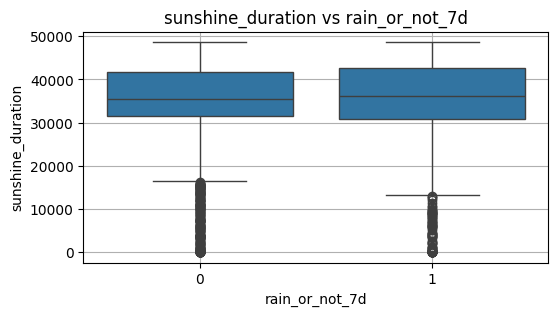

In [52]:
plot_feature_vs_target(daily_df,'sunshine_duration')

In [53]:
# <Student to fill this section>
feature_2_insights = """
Distribution highly left skewed. Outliers exist. Both the records look similar if it rained or not on t+7th day
"""

In [54]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.6 Explore Feature of Interest  `wind_speed_10m_max`, `wind_direction_10m_dominant`


In [55]:
temp = daily_df[['wind_speed_10m_max','wind_direction_10m_dominant']]

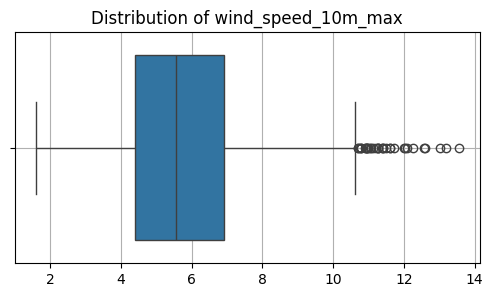

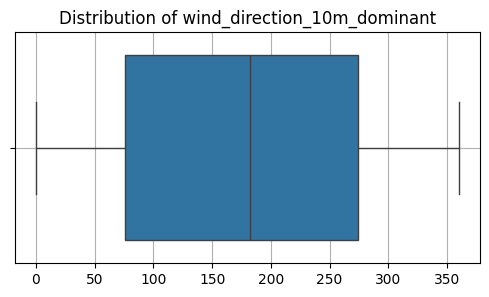

In [56]:
for col in temp.columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=temp[col])
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.grid()
    plt.show()

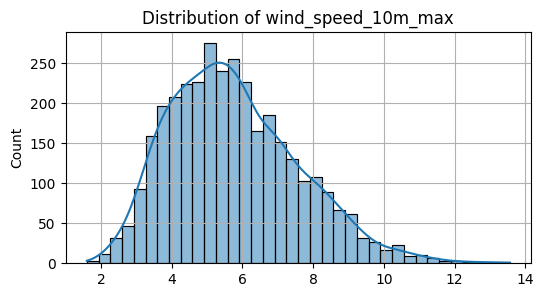

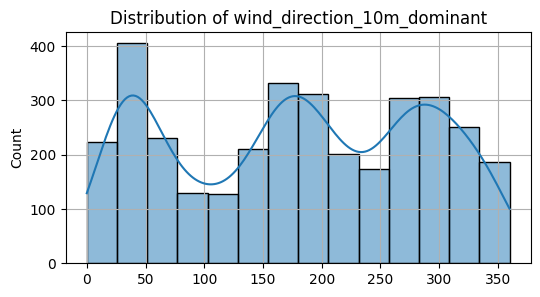

In [57]:
for col in temp.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(temp[col],kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.grid()
    plt.show()

In [58]:
temp['target'] = daily_df['rain_or_not_7d']

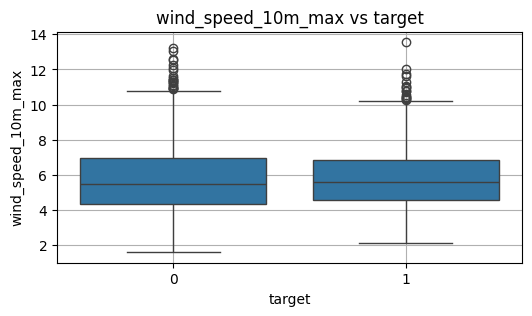

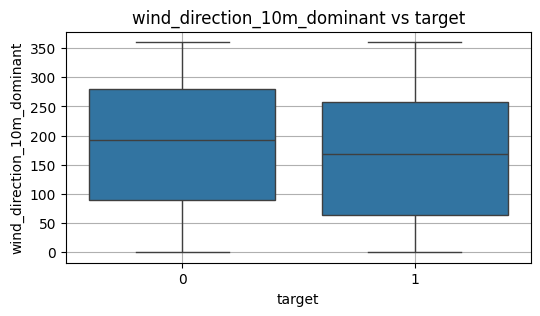

In [59]:
for col in temp.columns[0:-1]:
    plot_feature_vs_target(temp,col,'target')

In [60]:
# <Student to fill this section>
feature_n_insights = """
Wind speed has contains outliers, wind direction is uniformly spread and also seems to have a relation with target - slight change of wind direction on the days it rained on t+7th day.
"""

In [61]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)

---
## D. Feature Selection


### D.1 Correlation Matrix


<Axes: >

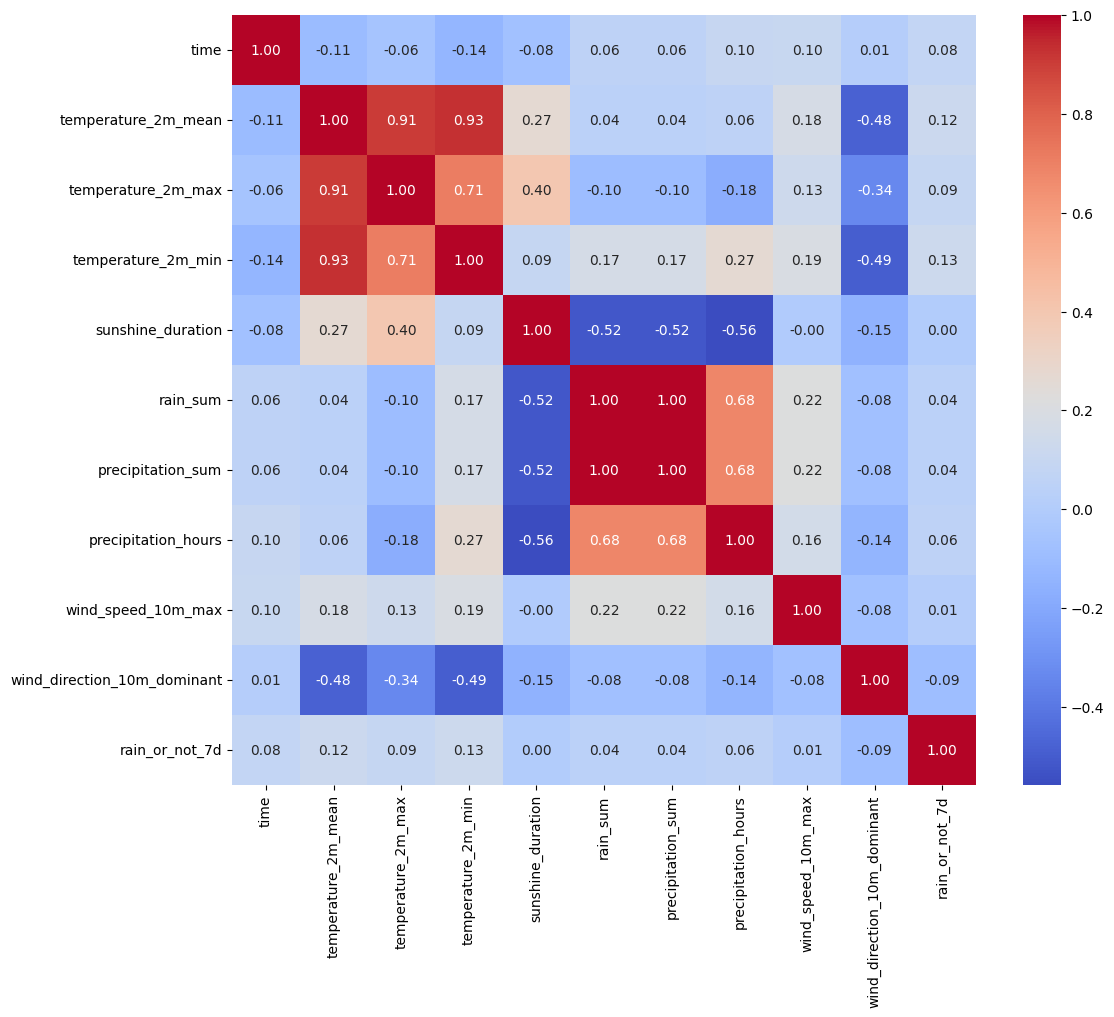

In [62]:
corr = daily_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

In [63]:
# <Student to fill this section>
feature_selection_1_insights = """
Multicollinearity observed for some features. There doesn't seem to be direct relation with the target. Next, we try RFE to find any relation between target and features.
"""

In [64]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Recursive Feature Elimination


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

cols_to_drop = ['time', 'rain_or_not_7d']

X = daily_df.drop(columns=cols_to_drop)
y = daily_df['rain_or_not_7d']

# Fit a RandomForest to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Create a dataframe of feature importances
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Choose a threshold (e.g., 0.01 for 1% importance)
threshold = 0.01
selected_features = feat_imp[feat_imp['importance'] >= threshold]['feature'].tolist()

print(feat_imp)

                       feature  importance
3            sunshine_duration    0.153427
7           wind_speed_10m_max    0.146421
8  wind_direction_10m_dominant    0.144354
2           temperature_2m_min    0.136838
1           temperature_2m_max    0.129428
0          temperature_2m_mean    0.124696
4                     rain_sum    0.058191
5            precipitation_sum    0.053819
6          precipitation_hours    0.052827


In [66]:
# <Student to fill this section>
feature_selection_2_insights = """
Top 3 features explain almost 45% of target. We will move forward with all the features for now except last 3.
"""

In [67]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

### D.3 Final Selection of Features

In [68]:
daily_df.columns

Index(['time', 'temperature_2m_mean', 'temperature_2m_max',
       'temperature_2m_min', 'sunshine_duration', 'rain_sum',
       'precipitation_sum', 'precipitation_hours', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'rain_or_not_7d'],
      dtype='object')

In [69]:
features_list = [
    'time', 'temperature_2m_min', 'temperature_2m_max',
    'sunshine_duration', 'wind_speed_10m_max',
    'wind_direction_10m_dominant', 'rain_or_not_7d'
]

# removed 'temperature_2m_mean' because of multicollinearity
# removed 'rain_sum', 'precipitation_sum', 'precipitation_hours' becasue of data leakage possibility

In [70]:
daily_df = daily_df[features_list]

In [71]:
# <Student to fill this section>
feature_selection_explanations = """
Given RFE and correlation matrix results, we decided to remove temperature_2m_mean because of multicollinearity. Three features- rain_sum, precipitation_sum and precipitation_hours are removed because they can cause data leakage.
"""

In [72]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Log transformation

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer

In [74]:
log_features = ['temperature_2m_min', 'temperature_2m_max', 'sunshine_duration']

log_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(func=lambda x: np.log1p(x), validate=False))
])

In [75]:
# <Student to fill this section>
data_cleaning_1_explanations = """
A log transformer pipeline is built to handle all the variables which require log transformation.
It is applied on min and max temperatures, and sunshine duration because of their distribution, right skewed. Log transformation will scale down all the observations.
"""

In [76]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Standardization

In [77]:
standard_features = ['wind_speed_10m_max', 'wind_direction_10m_dominant']

In [78]:
standard_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [79]:
# <Student to fill this section>
data_cleaning_2_explanations = """
Wind speed and wind direction have outliers, hence a scalar transform is applied.
"""

In [80]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Feature Engineering

In [81]:
time_feature = ['time']

In [82]:
time_transformer = FunctionTransformer(
    lambda x: pd.DataFrame({
        "day": pd.to_datetime(x.iloc[:, 0]).dt.day,
        "month": pd.to_datetime(x.iloc[:, 0]).dt.month,
        "year": pd.to_datetime(x.iloc[:, 0]).dt.year
    }, index=x.index),
    validate=False
)

In [83]:
# <Student to fill this section>
data_cleaning_3_explanations = """
Timestamp as such is useless, day, month and year is extracted from it to use it for model training.
"""

In [84]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### E.4 Running the pipeline

In [85]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_features),
        ('time', time_transformer, time_feature),
        ('standard', standard_transformer, standard_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [86]:
transformer = preprocessor.fit_transform(daily_df)

In [87]:
feature_names = []

# log features
feature_names += [f"log_{col}" for col in log_features]

# time features
feature_names += ["day", "month", "year"]

# standardized features
feature_names += [f"scaled_{col}" for col in standard_features]

# passthrough columns
passthrough_cols = [c for c in daily_df.columns if c not in log_features + standard_features + time_feature]
feature_names += passthrough_cols

In [88]:
df_eng = pd.DataFrame(
    transformer,
    columns=feature_names,
    index=daily_df.index
)

In [89]:
df_eng.head()

,log_temperature_2m_min,log_temperature_2m_max,log_sunshine_duration,day,month,year,scaled_wind_speed_10m_max,scaled_wind_direction_10m_dominant,rain_or_not_7d
0,2.714695,3.306887,10.587347,14.0,9.0,2015.0,0.894342,1.240331,0.0
1,2.533697,2.985682,10.592377,15.0,9.0,2015.0,-0.681333,-0.139421,0.0
2,2.549445,2.879198,10.509526,16.0,9.0,2015.0,-0.428786,-0.072812,0.0
3,2.674149,2.895912,10.584249,17.0,9.0,2015.0,-0.417806,-0.006203,1.0
4,2.674149,2.890372,10.537378,18.0,9.0,2015.0,-0.889959,-0.472464,0.0


In [90]:
# <Student to fill this section>
data_cleaning_4_explanations = """
All the transformers are ran in a pipeline, stored in a final dataframe.
"""

In [91]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_4_explanations', value=data_cleaning_4_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [92]:
# Compute split indices
n = len(df_eng)
train_end = int(0.7 * n)
val_end = int(0.8 * n)  # 70% + 10% = 80%

# Split
train_df = df_eng.iloc[:train_end].reset_index(drop=True)
val_df = df_eng.iloc[train_end:val_end].reset_index(drop=True)
test_df = df_eng.iloc[val_end:].reset_index(drop=True)

In [93]:
# Separate features and target
target_col = 'rain_or_not_7d'

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

In [94]:
# Check sizes
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (2373, 8) (2373,)
Validation: (339, 8) (339,)
Test: (678, 8) (678,)


In [95]:
# <Student to fill this section>
data_splitting_explanations = """
Time-based split preserves sequential order; the model sees past data first.
70/10/20 split: train has majority of data, val for hyperparameter tuning, test for final evaluation.
Resetting the index keeps things clean for downstream processing.
"""

In [96]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Transforming 2025 data using pipelines

In [97]:
test_2025 = df[df['time'] > '2025-01-01'] # to be used later for the final predictions

In [98]:
test_2025['rain_or_not_7d'] = (test_2025['rain_sum'].shift(-7) > 1).astype(int)
print(test_2025.shape)

# Drop the last 7 rows
test_2025 = test_2025.iloc[:-7]
print(test_2025.shape)

(257, 11)
(250, 11)


In [99]:
test_2025 = test_2025[features_list]

In [100]:
test_2025.shape

(250, 7)

In [101]:
# --- Apply preprocessing on test_2025 ---
test_2025_transformed = preprocessor.fit_transform(test_2025)

In [102]:
# Convert back to DataFrame with correct column names
test_2025_final = pd.DataFrame(
    test_2025_transformed,
    columns=feature_names,
    index=test_2025.index
)

In [103]:
# Rename columns to match your expected final schema
test_2025_final.columns = [
    "log_temperature_2m_min",
    "log_temperature_2m_max",
    "log_sunshine_duration",
    "day",
    "month",
    "year",
    "scaled_wind_speed_10m_max",
    "scaled_wind_direction_10m_dominant",
    "rain_or_not_7d"
]

In [104]:
# Split features and target
X_test_2025 = test_2025_final.drop(columns=["rain_or_not_7d"])
y_test_2025 = test_2025_final["rain_or_not_7d"]

In [105]:
print(X_test_2025.shape)
print(y_test_2025.shape)

(250, 8)
(250,)


In [106]:
# <Student to fill this section>
data_transformation_1_explanations = """
Same data transformations are applied to test_2025 data
"""

In [107]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

---
## H. Save Datasets

> Do not change this code

In [108]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

In [109]:
# Do not modify this code
# Save training set
try:
  X_test_2025.to_csv(at.folder_path / 'X_test_2025.csv', index=False)
  y_test_2025.to_csv(at.folder_path / 'y_test_2025.csv', index=False)
except Exception as e:
  print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [110]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
def evaluate_classification(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
        print(f"AUROC    : {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    return acc, prec, rec, f1, cm

In [111]:
# <Student to fill this section>
performance_metrics_explanations = """
Accuracy: overall correctness

Precision & Recall: important if rain class is rare

F1 Score: balances precision and recall

AUROC: evaluates the model’s ranking ability independent of threshold
"""

In [112]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Model Training

### J.1 Import Algorithm - Logistic Regression

> Provide some explanations on why you believe this algorithm is a good fit


In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [114]:
# <Student to fill this section>
algorithm_selection_explanations = """
Provide some explanations on why you believe this algorithm is a good fit
"""

In [115]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [116]:
# Define pipeline with only classifier (data is already preprocessed)
lr_pipeline = Pipeline([
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Hyperparameter grid for tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']
}

# GridSearchCV for tuning
lr_tuned = GridSearchCV(
    lr_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',  # optimize AUROC
    n_jobs=-1,
    verbose=1
)

In [117]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
Only the classifier is in the pipeline since features are already transformed.

Tuning uses AUROC because rain/no-rain is likely imbalanced.
"""

In [118]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [119]:
# Fit logistic regression on training data
# Fit tuned pipeline to the training data
lr_tuned.fit(X_train, y_train)

# Check best hyperparameters
print("Best parameters:", lr_tuned.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1'}


### J.4 Model Technical Performance

> Provide some explanations on model performance


In [120]:
# Validation set evaluation
y_val_pred = lr_tuned.predict(X_val)
y_val_proba = lr_tuned.predict_proba(X_val)[:, 1]  # probability for class 1
evaluate_classification(y_val, y_val_pred, y_val_proba)

# Test set evaluation
y_test_pred = lr_tuned.predict(X_test)
y_test_proba = lr_tuned.predict_proba(X_test)[:, 1]
evaluate_classification(y_test, y_test_pred, y_test_proba)

Accuracy : 0.5693
Precision: 0.4851
Recall   : 0.4577
F1 Score : 0.4710
AUROC    : 0.5789
Confusion Matrix:
[[128  69]
 [ 77  65]]
Accuracy : 0.5944
Precision: 0.4105
Recall   : 0.5223
F1 Score : 0.4597
AUROC    : 0.6054
Confusion Matrix:
[[286 168]
 [107 117]]


(0.5943952802359882,
 np.float64(0.4105263157894737),
 np.float64(0.5223214285714286),
 np.float64(0.45972495088408644),
 array([[286, 168],
        [107, 117]]))

In [121]:
# <Student to fill this section>
model_performance_explanations = """
Provide some explanations on model performance
"""

In [122]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [123]:
# <Student to fill this section>

In [124]:
# <Student to fill this section>
business_impacts_explanations = """
Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business (some results may have more impact compared to others)
"""

In [125]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

### J.6 Import Algorithm - Random Forest Classifier

In [126]:
from sklearn.ensemble import RandomForestClassifier

### J.7 Set Hyperparameters

In [127]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the base pipeline
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

# Hyperparameter search space
param_dist = {
    'rf__n_estimators': [50, 300],
    'rf__max_depth': randint(3, 15),
    'rf__min_samples_split': randint(2, 10),
    'rf__min_samples_leaf': randint(1, 5),
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

# Randomized search
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,              # number of random combinations
    scoring='roc_auc',      # AUROC as requested
    cv=5,                   # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)


### J.8 Fit Model

In [128]:
# Fit on training set
rf_random_search.fit(X_train, y_train)

# Best estimator after tuning
best_rf = rf_random_search.best_estimator_

print("Best Random Forest params:", rf_random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest params: {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}


### J.9 Model Technical Performance

In [129]:
# Predict on validation set
y_val_pred = best_rf.predict(X_val)
y_val_prob = best_rf.predict_proba(X_val)[:, 1]

# Evaluate on validation set
evaluate_classification(y_val, y_val_pred, y_val_prob)

# Predict on test set
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)[:, 1]

# Evaluate on test set
evaluate_classification(y_test, y_test_pred, y_test_prob)

Accuracy : 0.6018
Precision: 0.5714
Recall   : 0.1972
F1 Score : 0.2932
AUROC    : 0.5363
Confusion Matrix:
[[176  21]
 [114  28]]
Accuracy : 0.6342
Precision: 0.4167
Recall   : 0.2679
F1 Score : 0.3261
AUROC    : 0.6084
Confusion Matrix:
[[370  84]
 [164  60]]


(0.6342182890855457,
 np.float64(0.4166666666666667),
 np.float64(0.26785714285714285),
 np.float64(0.32608695652173914),
 array([[370,  84],
        [164,  60]]))

In [144]:
from pathlib import Path
import joblib
import os

# For Jupyter, safer way:
project_root = Path().resolve().parents[1]  # this points to saurabh-at2-eda-model

# Now build model path
model_path = project_root / "models" / "rain_or_not"
model_path.mkdir(parents=True, exist_ok=True)


# ---------------------------
# Save Random Forest Classifier
# ---------------------------
best_rf_model = best_rf  
rf_filename = os.path.join(model_path, "best_rf_model.pkl")
joblib.dump(best_rf_model, rf_filename)
print(f"Random Forest model saved successfully at: {rf_filename}")

Random Forest model saved successfully at: C:\Users\lenovo\Desktop\Labs Sem 2\Adv ML\at2\saurabh-at2-eda-model\models\rain_or_not\best_rf_model.pkl
